In [2]:
%matplotlib inline

In [3]:
import numpy as np

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [5]:
transform = transforms.Compose(
    [transforms.Resize((64, 64)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
face_data = torchvision.datasets.ImageFolder(root = '../data/face_age/', transform = transform)

In [7]:
face_data.target_transform = lambda id: float(face_data.classes[id])

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

image_range = list(range(len(face_data.imgs)))

train, test = train_test_split(image_range, test_size=.3)
valid, test = train_test_split(test, test_size=.3)

In [9]:
len(train), len(valid), len(test)

(6844, 2053, 881)

In [10]:
#BATCH SIZE
train_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                                sampler=SubsetRandomSampler(train))
valid_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                                sampler=SubsetRandomSampler(valid))
test_face_loader = torch.utils.data.DataLoader(face_data, batch_size=4, num_workers=4, 
                                               sampler=SubsetRandomSampler(test))

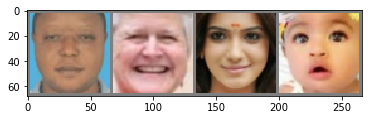

In [68]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_face_loader)
images, labels = dataiter.next()

# show images
out = torchvision.utils.make_grid(images)
imshow(out)

In [69]:
labels

tensor([26., 58., 18.,  2.], dtype=torch.float64)

In [ ]:
# classification (2 class ) - 1 out - 1 or 0 - nn.NLLLoss or nn.BCELoss
# classification (>2 class ) - n class out - [(1 or 0), (1 or 0), ... n] - CrossEntropyLoss
# regression 1 out - criteria - regressional - MSELoss

In [13]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()#64*64
        self.conv1 = nn.Conv2d(3, 6, 5)#60*60
        #self.batch1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)#30*30
        self.conv2 = nn.Conv2d(6, 16, 5)#26*26 - #13*13
        #self.batch2 = nn.BatchNorm2d(16)
        #self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        #self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        #self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.batch1(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.batch2(x)
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = self.fc3(x)
        return x


net = Net()

In [70]:
for parameter in net.parameters():
    print(parameter.data.shape)

torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 2704])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])


In [16]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cpu')

In [19]:
train_cases = 0
test_cases = 0
best_metric = 9999
best_epoch = 0
PATH = './face_regr.pth'
for epoch in range(10):  # loop over the dataset multiple times
    train_mse=0
    train_mae=0
    train_cases = 0  
    valid_mse=0
    valid_mae=0
    test_cases = 0
    for i, data in enumerate(train_face_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        net.train()
        with torch.set_grad_enabled(True):
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.float())
            outputs = torch.reshape(outputs, (-1,))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_mse += loss.item()
            train_mae += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
            train_cases += len(labels.numpy())
    for k, data in enumerate(valid_face_loader, 0):
        with torch.no_grad():
            images, labels = data
            net.eval()
            outputs = net(images)
            outputs = torch.reshape(outputs, (-1,))

            valid_mae += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
            valid_mse += sum(np.square(list(outputs.detach().numpy())-labels.numpy()))
            test_cases += len(labels.numpy())
    print(f'Epoch # {epoch}:', 
          '\t', f'train_mae {round(train_mae/train_cases, 2)} ',f'valid_mae {round(valid_mae/test_cases, 2)}',
          '\t', f'train_mse {round(train_mse/train_cases, 2)} ',f'valid_mse {round(valid_mse/test_cases, 2)}')
    #callback best model
    if valid_mae/test_cases<best_metric:
        best_metric = valid_mae/test_cases
        best_epoch = epoch
        torch.save(net.state_dict(), PATH)
    
    # early stopping  
    if epoch - best_epoch>3:
        break
        
print('Finished Training')

Epoch # 0: 	 train_mae 16.61  valid_mae 12.59 	 train_mse 130.81  valid_mse 321.36
Epoch # 1: 	 train_mae 11.08  valid_mae 10.19 	 train_mse 60.67  valid_mse 195.79
Epoch # 2: 	 train_mae 9.46  valid_mae 11.85 	 train_mse 46.35  valid_mse 301.06
Epoch # 3: 	 train_mae 8.47  valid_mae 11.43 	 train_mse 37.03  valid_mse 295.77
Epoch # 4: 	 train_mae 7.84  valid_mae 9.21 	 train_mse 31.64  valid_mse 190.03
Epoch # 5: 	 train_mae 7.2  valid_mae 9.1 	 train_mse 26.95  valid_mse 175.84
Epoch # 6: 	 train_mae 6.69  valid_mae 8.05 	 train_mse 23.31  valid_mse 144.93
Epoch # 7: 	 train_mae 6.45  valid_mae 8.15 	 train_mse 21.92  valid_mse 153.04
Epoch # 8: 	 train_mae 5.9  valid_mae 7.82 	 train_mse 18.14  valid_mse 144.52
Epoch # 9: 	 train_mae 5.65  valid_mae 7.68 	 train_mse 16.59  valid_mse 138.93
Finished Training


In [74]:
#uploading best model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

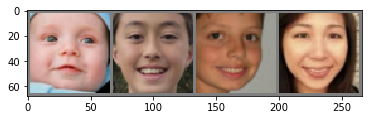

Predicted:  2.3515136 9.852959 8.384478 23.841509
Ground Truth:    1.0      14.0       8.0      28.0


In [75]:

dataiter = iter(test_face_loader)
images, labels = dataiter.next()
net.eval()
with torch.no_grad():
    outputs = net(images)
    outputs = torch.reshape(outputs, (-1,))
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('Predicted: ', ' '.join('%3s' % str(list(outputs.detach().numpy())[j])
                                  for j in range(4)))
    print('Ground Truth: ', '     '.join('%5s' % str(labels.numpy()[j])
                                  for j in range(4)))

In [76]:
abs_errors = 0
square_error = 0
net.eval()
with torch.no_grad():
    for data in test_face_loader:
        images, labels = data
        outputs = net(images)
        outputs = torch.reshape(outputs, (-1,))
        
        abs_errors += sum(abs(list(outputs.detach().numpy())-labels.numpy()))
        square_error += sum(np.square(list(outputs.detach().numpy())-labels.numpy()))

In [77]:
print('MAE: %.2f' % (abs_errors / len(test)))
print('MSE: %.1f' % (square_error / len(test)))

MAE: 7.60
MSE: 134.3


# Rotation

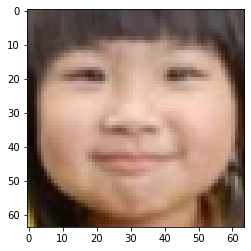

In [87]:
imshow(images.squeeze(0))

In [81]:
net(images)

tensor([[5.9387]], grad_fn=<AddmmBackward>)

In [100]:
rotation_transformer = torchvision.transforms.RandomRotation(45)

In [101]:
rand_image = rotation_transformer.forward(images)

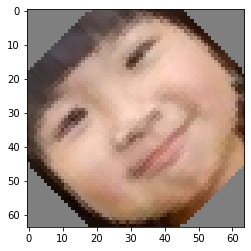

In [102]:
imshow(rand_image.squeeze(0))

In [103]:
net(rand_image)

tensor([[101.0942]], grad_fn=<AddmmBackward>)

In [78]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


# Embeddings

In [105]:
#uploading best model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [107]:
class Identity(nn.Module):
    def __init__(self, ):
        super().__init__()

    def forward(self, x):
        return x

In [108]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


In [109]:
net.fc3 = Identity()

In [129]:
H = 0
test_len = 0
valid_len = 0
train_len = 0
for data in train_face_loader:
    images, labels = data  
    train_len+= images.shape[0]
for data in valid_face_loader:
    
    images, labels = data
    valid_len+= images.shape[0]
for data in test_face_loader:
    images, labels = data
    test_len+= images.shape[0]
H = train_len + valid_len + test_len
W = 84
print(H, W)

9778 84


In [130]:
train_len, valid_len, test_len

(6844, 2053, 881)

In [116]:
embs = np.empty((H, W+1))
net.eval()
with torch.no_grad():
    i = 0
    for data in train_face_loader:
        images, labels = data
        outputs = net(images)
        embs[i: i+images.shape[0], :-1] = outputs
        embs[i: i+images.shape[0], -1] = labels
        i+=images.shape[0]
        
    for data in valid_face_loader:
        images, labels = data
        outputs = net(images)
        embs[i: i+images.shape[0], :-1] = outputs
        embs[i: i+images.shape[0], -1] = labels
        i+=images.shape[0]
    for data in test_face_loader:
        images, labels = data
        outputs = net(images)
        embs[i: i+images.shape[0], :-1] = outputs
        embs[i: i+images.shape[0], -1] = labels
        i+=images.shape[0]   

# LightGBM

In [121]:
import pandas as pd
import lightgbm as lgb

In [119]:
emb_pd = pd.DataFrame(embs).rename(columns={84: "Target"})

In [120]:
emb_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,Target
0,0.0,0.000000,0.743414,1.827337,2.610904,0.0,0.0,0.000000,3.782818,1.935308,...,0.0,0.000000,0.907433,0.000000,8.716543,0.000000,0.000000,0.119012,0.000,22.0
1,0.0,0.000000,3.736945,5.604437,6.811387,0.0,0.0,0.000000,7.334269,4.596219,...,0.0,0.000000,1.841928,0.000000,10.921914,0.770468,0.000000,0.000000,0.000,62.0
2,0.0,0.855154,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.472666,0.000000,7.339396,0.000000,1.494712,1.092869,0.246,21.0
3,0.0,0.000000,0.082437,0.588579,0.732167,0.0,0.0,0.000000,2.491543,0.845501,...,0.0,0.000000,0.981991,0.000000,8.360502,0.000000,0.077519,0.496880,0.000,18.0
4,0.0,4.172444,0.000000,0.000000,0.000000,0.0,0.0,0.411797,0.000000,0.000000,...,0.0,5.504887,1.600328,6.448594,0.000000,0.000000,5.119061,0.000000,0.000,1.0


In [126]:
emb_pd.iloc[:train_len, :-1]

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.0,0.000000,0.743414,1.827337,2.610904,0.0,0.0,0.0,3.782818,1.935308,...,1.429178,0.0,0.0,0.907433,0.0,8.716543,0.000000,0.000000,0.119012,0.000
1,0.0,0.000000,3.736945,5.604437,6.811387,0.0,0.0,0.0,7.334269,4.596219,...,4.821644,0.0,0.0,1.841928,0.0,10.921914,0.770468,0.000000,0.000000,0.000
2,0.0,0.855154,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.472666,0.0,7.339396,0.000000,1.494712,1.092869,0.246
3,0.0,0.000000,0.082437,0.588579,0.732167,0.0,0.0,0.0,2.491543,0.845501,...,0.000000,0.0,0.0,0.981991,0.0,8.360502,0.000000,0.077519,0.496880,0.000


In [134]:
train = lgb.Dataset(emb_pd.iloc[:train_len, :-1], emb_pd.iloc[:train_len, -1])
valid = lgb.Dataset(emb_pd.iloc[train_len:train_len+valid_len, :-1], emb_pd.iloc[train_len:train_len+valid_len, -1])

In [145]:
params = {"objective": "mse", "n_estimators": 1000, "learning_rate":0.01}

bst = lgb.train(
            params,
            train_set=train,
            valid_names=["eval", "train"],
            valid_sets=[valid, train],
            verbose_eval=50,
            early_stopping_rounds=300,
        )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18722
[LightGBM] [Info] Number of data points in the train set: 6844, number of used features: 81
[LightGBM] [Info] Start training from score 29.458650
Training until validation scores don't improve for 300 rounds
[50]	train's l2: 251.708	eval's l2: 299.929
[100]	train's l2: 116.949	eval's l2: 185.787
[150]	train's l2: 65.9654	eval's l2: 145.102
[200]	train's l2: 45.9125	eval's l2: 131.108
[250]	train's l2: 37.3054	eval's l2: 126.304
[300]	train's l2: 33.047	eval's l2: 124.774
[350]	train's l2: 30.5548	eval's l2: 124.632
[400]	train's l2: 28.7704	eval's l2: 124.652
[450]	train's l2: 27.3621	eval's l2: 124.85
[500]	train's l2: 26.1633	eval's l2: 124.986
[550]	train's l2: 25.116	eval's l2: 125.005
[600]	train's l2: 24.2139	eval's l2: 

In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [147]:
y_pred = bst.predict(emb_pd.iloc[train_len+valid_len:, :-1])
y_true = emb_pd.iloc[train_len+valid_len:, -1]
print(y_pred.shape, y_true.shape)

(881,) (881,)


In [148]:
mean_squared_error(y_true, y_pred)

115.0483865186014

In [149]:
mean_absolute_error(y_true, y_pred)

7.098483724652702

# Simular vectors

In [152]:
correlation = emb_pd.iloc[:, :-1].T.corr()

,0,1,2,3,4,5,6,7,8,9,...,9768,9769,9770,9771,9772,9773,9774,9775,9776,9777
0,1.000000,0.884478,0.712351,0.939139,-0.300945,0.624052,0.994369,0.750311,0.051008,0.823964,...,0.855417,0.993957,-0.300501,0.939845,0.986881,0.843270,0.986970,0.931996,0.953918,0.976651
1,0.884478,1.000000,0.403920,0.706374,-0.366746,0.320780,0.871508,0.444859,-0.125751,0.986469,...,0.983130,0.869876,-0.360109,0.981534,0.930831,0.554512,0.840892,0.694736,0.738950,0.946318
2,0.712351,0.403920,1.000000,0.849904,0.053197,0.935150,0.735712,0.992879,0.467585,0.306141,...,0.393210,0.716903,0.043227,0.497750,0.651153,0.937158,0.773212,0.872993,0.852866,0.617054
3,0.939139,0.706374,0.849904,1.000000,-0.183241,0.764998,0.952855,0.888348,0.215247,0.614278,...,0.666605,0.948040,-0.181457,0.785765,0.894068,0.958982,0.964432,0.993249,0.983532,0.860325
4,-0.300945,-0.366746,0.053197,-0.183241,1.000000,0.114487,-0.280380,0.024484,0.778514,-0.359463,...,-0.356631,-0.279244,0.983967,-0.347859,-0.321423,-0.090469,-0.271496,-0.179881,-0.190787,-0.325879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9773,0.843270,0.554512,0.937158,0.958982,-0.090469,0.864411,0.864207,0.961440,0.331510,0.453060,...,0.530763,0.850484,-0.097425,0.643816,0.778784,1.000000,0.895138,0.966063,0.935484,0.748249
9774,0.986970,0.840892,0.773212,0.964432,-0.271496,0.688153,0.989888,0.808865,0.112035,0.773823,...,0.818096,0.987533,-0.270742,0.903967,0.966465,0.895138,1.000000,0.961418,0.968455,0.955413
9775,0.931996,0.694736,0.872993,0.993249,-0.179881,0.787851,0.947370,0.905967,0.230826,0.599690,...,0.658879,0.939483,-0.174585,0.774334,0.887905,0.966063,0.961418,1.000000,0.986129,0.854003
9776,0.953918,0.738950,0.852866,0.983532,-0.190787,0.758578,0.962698,0.881499,0.197880,0.654125,...,0.705816,0.956302,-0.185933,0.817424,0.917362,0.935484,0.968455,0.986129,1.000000,0.889761


In [153]:
face_data[9774]

(tensor([[[-0.6235, -0.6627, -0.6706,  ..., -0.3255, -0.3020, -0.3333],
          [-0.6549, -0.6863, -0.6863,  ..., -0.3647, -0.3176, -0.3176],
          [-0.6941, -0.7098, -0.7176,  ..., -0.4118, -0.3569, -0.3412],
          ...,
          [-0.4353, -0.5294, -0.6392,  ..., -0.3961, -0.3725, -0.4039],
          [-0.3961, -0.4824, -0.6314,  ..., -0.3490, -0.3412, -0.3804],
          [-0.3569, -0.4039, -0.6471,  ..., -0.3020, -0.3020, -0.3569]],
 
         [[-0.7020, -0.7412, -0.7490,  ..., -0.3804, -0.3490, -0.3882],
          [-0.7333, -0.7569, -0.7647,  ..., -0.4353, -0.3804, -0.3882],
          [-0.7569, -0.7804, -0.7804,  ..., -0.4980, -0.4275, -0.4196],
          ...,
          [-0.4431, -0.5373, -0.6471,  ..., -0.4667, -0.4431, -0.4745],
          [-0.4275, -0.4980, -0.6392,  ..., -0.4275, -0.4118, -0.4510],
          [-0.3882, -0.4275, -0.6549,  ..., -0.3804, -0.3725, -0.4275]],
 
         [[-0.7725, -0.8118, -0.8196,  ..., -0.4667, -0.4431, -0.4667],
          [-0.7882, -0.8196,